## PSF generator
## Gibson-Lanni model
### Fast and accurate three-dimensional point spread function computation for fluorescence microscopy by Li, Xue, and Blu.
the approach is fast because it avoids the need to perform any explicit integration of the Kirchhoff diffraction integral, such as is done in PSF Generator. The prototype is based on the manuscript and the associated MATLAB code at http://www.ee.cuhk.edu.hk/~tblu/monsite/phps/fastPSF.php

link from : http://kmdouglass.github.io/posts/implementing-a-fast-gibson-lanni-psf-solver-in-python/

In [74]:
import sys
%pylab inline
import scipy.special
from scipy.interpolate import interp1d
from matplotlib import animation
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#272b30'
plt.rcParams['image.cmap'] = 'viridis'

print('Python {}\n'.format(sys.version))
print('NumPy\t\t{}'.format(np.__version__))
print('matplotlib\t{}'.format(matplotlib.__version__))
print('SciPy\t\t{}'.format(scipy.__version__))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Python 3.8.5 (tags/v3.8.5:580fbb0, Jul 20 2020, 15:57:54) [MSC v.1924 64 bit (AMD64)]

NumPy		1.22.3
matplotlib	3.2.2
SciPy		1.4.1


C:\Users\www_0\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['imread']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Simulation setup
## Define the simulation parameters
The Gibson-Lanni PSF model accounts for differences between design parameters and real parameters that describe the fluorescence microscope, such as the refractive indexes and thicknesses of the immersion medium, coverslip, and sample. For more information, please see the above references or, if you do not have access to the publications, the description of the model here:


分辨率=0.16*λ/NA  

Parameter | Description
----------|------------
NA | Numerical Aperture of the objective lens. This value is given by NA = ni sin(Θ) where Θ is one half of the angular aperture of the lens.
ns | Refractive index of the sample layer.
ts | Axial location of the point source within the sample layer. The corresponding input field in the plugin is "z".
ng | Actual value of the refractive index of the coverslip. This value is assumed to be equal to ng* and it is therefore not used by the plugin.
ng* | Nominal value of the refractive index of the coverslip. This value is assumed to be equal to ng and it is therefore not used by the plugin.
ni | Actual value of the refractive index of the immersion layer (the paper by Gibson and Lanni uses the notations noil).
ni* | Nominal value of the refractive index of the immersion layer (the paper by Gibson and Lanni paper uses the notations noil*. This value is assumed to be equal to ni and it is therefore not used by the plugin.
tg | Actual value of the coverslip thickness. This value is assumed to be equal to tg* and it is therefore not used by the plugin.
tg* | Nominal value of the coverslip thickness. This value is assumed to be equal to tg and it is therefore not used by the plugin.
ti | Actual working distance between the objective and the coverslip (the Gibson and Lanni paper uses the notation toil).
ti* | Nominal working distance between the objective lens and the coverslip (the Gibson and Lanni paper uses the notation toil*). This value is given by ti* = ti + Δ where Δ is the stage displacement. When generating a z-stack, stage displacement values are determined by the "Axial resolution" and by the "slices" input parameters of the plugin. If the number of slices is odd, then the middle slice corresponds to Δ = 0.
λ | Wavelength of the light emitted by the point source.
k | Wavenumber in vacuum of the emitted light, k = 2Π/λ.
xd, yd | Lateral position for evaluating the PSF at the detector plane. The sampling points are {xd,n, yd,m} = {nΔ, mΔ}n,m where Δ is the value of the "Pixel size in object space" input parameter, n = - (N-1)/2 ... (N-1)/2 and m = - (M-1)/2 ... (M-1)/2. N and M are the "width" and the "height" input parameters, respectively of the plugin. If N and M are odd, then the middle pixel is (0,0).
zd | Axial distance between the detector and the tube lens. This value is assumed to be equal to the focal length of the tube lens, and for this reason the plugin substitutes NA = a/zd in h(x, y, z).
W | The Gibson and Lanni phase aberration.
C | A normalizing constant. The value C/zd that appear in h(x, y, z) is determined by the "normalization" input parameter of the plugin.

![alt](./images/gl-diagram.png)

In [75]:
# Image properties
# Size of the PSF array, pixels
size_x = 50
size_y = 50
size_z = 10

# Precision control
num_basis    = 100  # Number of rescaled Bessels that approximate the phase function
num_samples  = 1000 # Number of pupil samples along radial direction
oversampling = 2    # Defines the upsampling ratio on the image space grid for computations

# Microscope parameters
NA          = 1.4
wavelength  = 0.516 # microns
M           = 1   # magnification
ns          = 1.33  # specimen refractive index (RI)
ng0         = 1.5   # coverslip RI design value
ng          = 1.5   # coverslip RI experimental value
ni0         = 1.5   # immersion medium RI design value
ni          = 1.5   # immersion medium RI experimental value
ti0         = 150   # microns, working distance (immersion medium thickness) design value
tg0         = 170   # microns, coverslip thickness design value
tg          = 170   # microns, coverslip thickness experimental value
res_lateral = 0.16   # microns
res_axial   = 0.3  # microns
pZ          = 0     # microns, particle distance from coverslip

# Scaling factors for the Fourier-Bessel series expansion
min_wavelength = 0.436 # microns
scaling_factor = NA * (3 * np.arange(1, num_basis + 1) - 2) * min_wavelength / wavelength

### Create the coordinate systems
![fomula](./images/gl-formula.png)  
k = 2Π/λ.


In [76]:
# Place the origin at the center of the final PSF array
x0 = (size_x - 1) / 2
y0 = (size_y - 1) / 2

# Find the maximum possible radius coordinate of the PSF array by finding the distance
# from the center of the array to a corner
max_radius = round(np.sqrt((size_x - x0) * (size_x - x0) + (size_y - y0) * (size_y - y0))) + 1;

# Radial coordinates, image space
r = res_lateral * np.arange(0, oversampling * max_radius) / oversampling

# Radial coordinates, pupil space
a = min([NA, ns, ni, ni0, ng, ng0]) / NA
print("a :",a)
rho = np.linspace(0, a, num_samples)
print("rho shape",rho.shape)

# Stage displacements away from best focus
z = res_axial * np.arange(-size_z / 2, size_z /2) + res_axial / 2

a : 0.9500000000000001
rho shape (1000,)


OPDs shape : (1000,)
OPDi shape : (10, 1000)
OPDg shape : (1000,)
W shape : (10, 1000)
C shape : (100, 10)
residuals shape : (10,)
J.T shape : (1000, 100)
phase.T shape : (1000, 10)


C:\Users\www_0\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


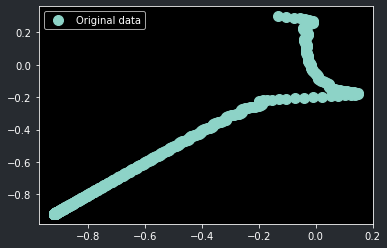

In [77]:
# Define the wavefront aberration
OPDs = pZ * np.sqrt(ns * ns - NA * NA * rho * rho) # OPD in the sample
OPDi = (z.reshape(-1,1) + ti0) * np.sqrt(ni * ni - NA * NA * rho * rho) - ti0 * np.sqrt(ni0 * ni0 - NA * NA * rho * rho) # OPD in the immersion medium
OPDg = tg * np.sqrt(ng * ng - NA * NA * rho * rho) - tg0 * np.sqrt(ng0 * ng0 - NA * NA * rho * rho) # OPD in the coverslip
W    = 2 * np.pi / wavelength * (OPDs + OPDi + OPDg)

# Sample the phase
# Shape is (number of z samples by number of rho samples)
phase = np.cos(W) + 1j * np.sin(W)

# Define the basis of Bessel functions
# Shape is (number of basis functions by number of rho samples)
J = scipy.special.jv(0, scaling_factor.reshape(-1, 1) * rho)

# Compute the approximation to the sampled pupil phase by finding the least squares
# solution to the complex coefficients of the Fourier-Bessel expansion.
# Shape of C is (number of basis functions by number of z samples).
# Note the matrix transposes to get the dimensions correct.
# lstsq的输出包括四部分：回归系数、残差平方和、自变量X的秩、X的奇异值。
C, residuals, _, _ = np.linalg.lstsq(J.T, phase.T,rcond=None)
print("OPDs shape :",OPDs.shape)
print("OPDi shape :",OPDi.shape)
print("OPDg shape :",OPDg.shape)
print("W shape :",W.shape)
print("C shape :",C.shape)
print("residuals shape :",residuals.shape)
print("J.T shape :",J.T.shape)
print("phase.T shape :",phase.T.shape)

# plot fitting data
import matplotlib.pyplot as plt
_ = plt.plot((J.T.dot(C))[:,5], phase.T[:,5], 'o', label='Original data', markersize=10)

_ = plt.legend()
plt.show()

skip it , just test `lstsq` function

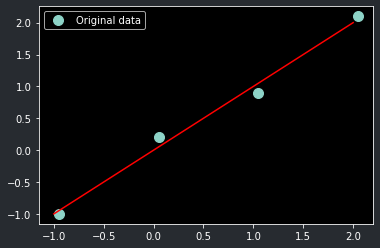

In [78]:
x = np.array([0, 1, 2, 3])
y = np.array([-1, 0.2, 0.9, 2.1])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y, rcond=None)[0]
import matplotlib.pyplot as plt
_ = plt.plot(m*x + c, y, 'o', label='Original data', markersize=10)
_ = plt.plot([-1,2], [-1,2], 'r')
_ = plt.legend()
plt.show()

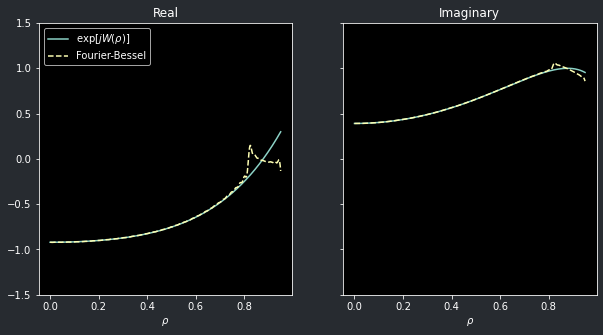

In [79]:
# Which z-plane to compute
z0 = 5

# The Fourier-Bessel approximation
est = J.T.dot(C[:,z0])

fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
ax[0].plot(rho, np.real(phase[z0, :]), label=r'$ \exp{ \left[ jW \left( \rho \right) \right] }$')
ax[0].plot(rho, np.real(est), '--', label='Fourier-Bessel')
ax[0].set_xlabel(r'$\rho$')
ax[0].set_title('Real')
ax[0].legend(loc='upper left')

ax[1].plot(rho, np.imag(phase[z0, :]))
ax[1].plot(rho, np.imag(est), '--')
ax[1].set_xlabel(r'$\rho$')
ax[1].set_title('Imaginary')
ax[1].set_ylim((-1.5, 1.5))

plt.show()

Step 2: Compute the PSF  
Here, we use the Fourier-Bessel series expansion of the phase function and a Bessel integral identity to compute the approximate PSF. Each coefficient c_m(z) needs to be multiplied by  

$$\begin{equation*}
R \left(r; \mathbf{p} \right) = \frac{\sigma_m J_1 \left( \sigma_m a \right) J_0 \left( \beta a \right)a - \beta J_0 \left( \sigma_m a \right) J_1 \left( \beta a \right)a }{\sigma_m^2 - \beta^2}
\end{equation*}$$

and the resulting products summed over the number of basis functions. p is the parameter vector for the Gibson-Lanni model, σm is the scaling factor for the argument to the m′th Bessel basis function, and β=krNA.  

b is defined such that R has dimensions of len(r) × len(rho).  

In [80]:
b = 2 * np. pi * r.reshape(-1, 1) * NA / wavelength

# Convenience functions for J0 and J1 Bessel functions
J0 = lambda x: scipy.special.jv(0, x)
J1 = lambda x: scipy.special.jv(1, x)

# See equation 5 in Li, Xue, and Blu
denom = scaling_factor * scaling_factor - b * b
R = (scaling_factor * J1(scaling_factor * a) * J0(b * a) * a - b * J0(scaling_factor * a) * J1(b * a) * a)
R /= denom


Now compute the point-spread function via

$$(\begin{equation*}
PSF \left( r, z; z_p, \mathbf{p} \right) = \left| \mathbf{R} \left( r; \mathbf{p} \right) \mathbf{c} \left( z \right) \right|^2
\end{equation*})$$

In [81]:
# The transpose places the axial direction along the first dimension of the array, i.e. rows
# This is only for convenience.
PSF_rz = (np.abs(R.dot(C))**2).T

# Normalize to the maximum value
PSF_rz /= np.max(PSF_rz)

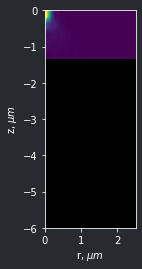

In [82]:
fig, ax = plt.subplots()

ax.imshow(PSF_rz, extent=(r.min(), r.max(), z.max(), z.min()))
ax.set_xlim((0,2.5))
ax.set_ylim((-6, 0))
ax.set_xlabel(r'r, $\mu m$')
ax.set_ylabel(r'z, $\mu m$')

plt.show()

Step 3: Resample the PSF onto a rotationally-symmetric Cartesian grid
Here we generate a two dimensional grid where the value at each grid point is the distance of the point from the center of the grid. These values are supplied to an interpolation function computed from PSF_rz to produce a rotationally-symmetric 2D PSF at each z-position.

In [83]:
# Create the fleshed-out xy grid of radial distances from the center
xy      = np.mgrid[0:size_y, 0:size_x]
r_pixel = np.sqrt((xy[1] - x0) * (xy[1] - x0) + (xy[0] - y0) * (xy[0] - y0)) * res_lateral

PSF = np.zeros((size_y, size_x, size_z))

for z_index in range(PSF.shape[2]):
    # Interpolate the radial PSF function
    PSF_interp = interp1d(r, PSF_rz[z_index, :])
    
    # Evaluate the PSF at each value of r_pixel
    PSF[:,:, z_index] = PSF_interp(r_pixel.ravel()).reshape(size_y, size_x)

In [84]:
fig, ax    = plt.subplots(nrows=1, ncols=1)

# Rescale the PSF values logarithmically for better viewing
PSF_log = np.log(PSF)
vmin, vmax = PSF_log.min(), PSF_log.max()

img = ax.imshow(PSF[:,:,5], vmin=vmin, vmax=vmax)
img.set_extent([-r.max(), r.max(), -r.max(), r.max()])

txt = ax.text(3, 7, 'z = {:.1f} $\mu m$'.format(z[5]))
ax.set_xlim((-8, 8))
ax.set_xticks((-5, 0, 5))
ax.set_xlabel(r'x, $\mu m$')
ax.set_ylim((-8, 8))
ax.set_yticks((-5, 0, 5))
ax.set_ylabel(r'y, $\mu m$')
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

# Initialize the figure with an empty frame
def init():
    img.set_data(np.zeros((size_y, size_x)))
    return img,

# This function is called for each frame of the animation
def animate(frame):   
    img.set_data(np.log(PSF[:, :, frame]))

    txt.set_text('z = {:.1f} $\mu m$'.format(z[frame]))
    return img,

# Create the animation
anim = animation.FuncAnimation(fig, animate, frames=len(z),
                               init_func=init, interval=20, blit=True)

# Save the animation
plt.rcParams['animation.ffmpeg_path'] = r'F:\dev\msys64\opt\windows_64\bin\ffmpeg.exe'
myWriter = animation.FFMpegWriter(fps=10, extra_args=['-vcodec', 'libx264'])
anim.save('images/gibson-lanni.mp4', writer = myWriter)
    
plt.close()

In [85]:
PSF.shape

(50, 50, 10)

In [89]:
# save psf image
import tifffile
from tifffile import imread,imwrite
import skimage
#imwrite( "./images/gibson-lanni.tif", np.array(PSF) ,photometric='rgb',metadata={'axes': 'XYZ'}) 
#skimage.io.imsave("./images/gibson-lanni.tif", PSF)
PSFS=np.swapaxes(PSF,0,2)
skimage.io.imsave("./images/gibson-lanni.tif", PSFS)

C:\Users\www_0\AppData\Local\Temp\ipykernel_19308\3909311358.py:8: UserWarning: ./images/gibson-lanni.tif is a low contrast image
  skimage.io.imsave("./images/gibson-lanni.tif", PSFS)
